In [10]:
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from Evaluation.Evaluator import EvaluatorHoldout
from Data_Handler.DataReader import DataReader
import scipy.sparse as sps
from collections import Counter
from tqdm import tqdm
# imports for .env usage
import os
from dotenv import load_dotenv
load_dotenv()



True

In [11]:
from Data_Handler.DataReader import DataReader 
dataReader=DataReader()
'''urm=dataReader.load_augmented_binary_urm()
powerful_urm=dataReader.load_powerful_binary_urm()
URM_pad,icm = dataReader.pad_with_zeros_ICMandURM(urm)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(urm, train_percentage = 0.9)
train_powerful, val_powerful = split_train_in_two_percentage_global_sample(powerful_urm, train_percentage = 0.9)
train_pad, val_pad = split_train_in_two_percentage_global_sample(URM_pad, train_percentage = 0.9)'''

URM = dataReader.load_augmented_binary_urm()
URM_aug,ICM = dataReader.pad_with_zeros_ICMandURM(URM)

URM_train_aug, URM_validation = split_train_in_two_percentage_global_sample(URM_aug, train_percentage = 0.9)
URM_train_pow = dataReader.stackMatrixes(URM_train_aug)
UCM = dataReader.load_aug_ucm()


Making augmented URM and ICM of the same shape...


In [12]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train_aug).indptr)
profile_length, profile_length.shape

(array([59, 17, 88, ..., 21, 46, 18], dtype=int32), (41629,))

In [13]:
block_size = int(len(profile_length)*0.05)
block_size

2081

In [14]:
sorted_users = np.argsort(profile_length)
sorted_users

array([38400, 36096, 41083, ..., 19407,  8693, 12454])

In [15]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 2081, average p.len 11.44, median 12.0, min 4, max 13
Group 1, #users in group 2081, average p.len 14.35, median 14.0, min 13, max 15
Group 2, #users in group 2081, average p.len 15.92, median 16.0, min 15, max 17
Group 3, #users in group 2081, average p.len 17.36, median 17.0, min 17, max 18
Group 4, #users in group 2081, average p.len 18.56, median 19.0, min 18, max 19
Group 5, #users in group 2081, average p.len 19.75, median 20.0, min 19, max 20
Group 6, #users in group 2081, average p.len 20.99, median 21.0, min 20, max 22
Group 7, #users in group 2081, average p.len 22.30, median 22.0, min 22, max 23
Group 8, #users in group 2081, average p.len 23.55, median 24.0, min 23, max 24
Group 9, #users in group 2081, average p.len 24.99, median 25.0, min 24, max 26
Group 10, #users in group 2081, average p.len 26.59, median 27.0, min 26, max 28
Group 11, #users in group 2081, average p.len 28.47, median 28.0, min 28, max 29
Group 12, #users in group 2081, average

In [16]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.KNN.UserKNN_CFCBF_Hybrid_Recommender import UserKNN_CFCBF_Hybrid_Recommender
from hybrid import *
from Recommenders.SLIM.SLIMElasticNetRecommender import *
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

from Recommenders.FactorizationMachines.LightFMRecommender import LightFMItemHybridRecommender

MAP_recommender_per_group = {}

ItemKNNCF = ItemKNNCFRecommender(URM_train_pow)
ItemKNNCF.fit()

RP3beta_pow = RP3betaRecommender(URM_train_pow)
RP3beta_pow.fit(alpha=0.3648761546066018,beta=0.5058870363874656, topK=480, normalize_similarity=True)

UserKNNCF = UserKNNCFRecommender(URM_train_aug)
UserKNNCF.fit()

RP3beta_aug = RP3betaRecommender(URM_train_aug)
RP3beta_aug.fit(alpha=0.6951524535062256,beta=0.39985511876562174, topK=82, normalize_similarity=True)

S_SLIM = SLIMElasticNetRecommender(URM_train_pow)
S_SLIM.fit()

EASE_R = EASE_R_Recommender(URM_train_aug)
EASE_R.fit()

Hybrid_UserKNNCF_RP3B_aug = Hybrid_UserKNNCF_RP3B_aug(
    URM_train_aug, URM_train_pow, UserKNNCF, RP3beta_aug)
Hybrid_UserKNNCF_RP3B_aug.fit(
    UserKNNCF_weight=0.4348857237366932, RP3B_weight=0.027648314372221712)

Hybrid_SSLIM_EASER = Hybrid_SSLIM_EASER(
    URM_train_aug, URM_train_pow, S_SLIM, EASE_R)
Hybrid_SSLIM_EASER.fit(SSLIM_weight=0.5495139584252299, EASE_R_weight=0.0)

Hybrid_SSLIM_RP3B_aug = Hybrid_SSLIM_RP3B_aug(
    URM_train_aug, URM_train_pow, S_SLIM, RP3beta_aug)
Hybrid_SSLIM_RP3B_aug.fit(
    SSLIM_weight=0.26204559437361846, RP3B_weight=0.46562963809236146)

Hybrid_UserKNNCF_ItemKNNCF = Hybrid_UserKNNCF_ItemKNNCF(
    URM_train_aug, URM_train_pow, UserKNNCF, ItemKNNCF)
Hybrid_UserKNNCF_ItemKNNCF.fit(
    UserKNNCF_weight=1.0, ItemKNNCF_weight=0.8072073132929845)

Hybrid_User_and_Item_KNN_CFCBF_Hybrid = Hybrid_User_and_Item_KNN_CFCBF_Hybrid(
    URM_train_aug, URM_train_pow, ItemKNN_CFCBF_Hybrid_Recommender, UserKNN_CFCBF_Hybrid_Recommender)
Hybrid_User_and_Item_KNN_CFCBF_Hybrid.fit()

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 785.69 column/sec. Elapsed time 35.60 sec
RP3betaRecommender: Similarity column 27968 (100.0%), 1831.44 column/sec. Elapsed time 15.27 sec
UserKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 830.28 column/sec. Elapsed time 50.14 sec
RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 4865.24 column/sec. Elapsed time 5.75 sec
SLIMElasticNetRecommender: Processed 7710 (27.6%) in 5.00 min. Items per second: 25.69
SLIMElasticNetRecommender: Processed 15823 (56.6%) in 10.00 min. Items per second: 26.37
SLIMElasticNetRecommender: Processed 23950 (85.6%) in 15.00 min. Items per second: 26.61
SLIMElasticNetRecommender: Processed 27968 (100.0%) in 15.72 min. Items per second: 29.64
EASE_R_Recommender: URM De

In [19]:
collaborative_recommender_class = {
        #"SLIMElasticNetRecommender": SLIMElasticNetRecommender,
        "UserKNNCF": UserKNNCFRecommender,
        "ItemKNNCF": ItemKNNCFRecommender,
        #"RP3betaRecommender_aug": RP3betaRecommender,
        #"RP3betaRecommender_pow": RP3betaRecommender,
        #"EASE_R": EASE_R_Recommender,
        #"HybridRecommender_5" : HybridRecommender_5,
        "Hybrid_Best": Hybrid_Best,
        "Hybrid_SSLIM_EASER": Hybrid_SSLIM_EASER,
        "Hybrid_SSLIM_RP3B_aug": Hybrid_SSLIM_RP3B_aug,
        "Hybrid_UserKNNCF_RP3B_aug": Hybrid_UserKNNCF_RP3B_aug,
        "Hybrid_UserKNNCF_ItemKNNCF": Hybrid_UserKNNCF_ItemKNNCF,
        "Hybrid_User_and_Item_KNN_CFCBF_Hybrid": Hybrid_User_and_Item_KNN_CFCBF_Hybrid,
}

recommender_object_dict = {}
recommended_items_for_each_user = {}

for label, recommender_class in collaborative_recommender_class.items():
    if(label == "SLIMElasticNetRecommender" or label == "RP3betaRecommender_pow"):
        recommender_object = recommender_class(URM_train_pow)
        recommender_object.fit()
    
    elif label == "HybridRecommender_5":
        recommender_object = recommender_class(URM_train_aug, URM_train_pow, UserKNNCF, RP3beta_pow, S_SLIM, EASE_R)
        recommender_object.fit()

    elif label == "Hybrid_Best":
        recommender_object = recommender_class(URM_train_aug, URM_train_pow, ICM, UCM, Hybrid_SSLIM_RP3B_aug,
                                 Hybrid_UserKNNCF_ItemKNNCF, UserKNNCF, Hybrid_UserKNNCF_RP3B_aug, Hybrid_SSLIM_EASER)
        recommender_object.fit(Hybrid_1_tier1_weight = 0.5960289190957877, Hybrid_2_tier1_weight = 1.0, Hybrid_1_tier2_weight = 1.0, Hybrid_2_tier2_weight = 0.0, Hybrid_1_tier3_weight = 0.4001445272204769, Hybrid_2_tier3_weight = 0.6909775763230392)

    elif label == "Hybrid_SSLIM_EASER":
        recommender_object = recommender_class(URM_train_aug, URM_train_pow, S_SLIM, EASE_R)
        recommender_object.fit(SSLIM_weight=0.563368095251961, EASE_R_weight=0.0)
    
    elif label == "Hybrid_SSLIM_RP3B_aug":
        recommender_object = recommender_class(URM_train_aug, URM_train_pow, S_SLIM, RP3beta_aug)
        recommender_object.fit(SSLIM_weight= 0.8157521052599057, RP3B_weight=0.22946157569349823)
    
    elif label == "Hybrid_UserKNNCF_RP3B_aug":
        recommender_object = recommender_class(URM_train_aug, URM_train_pow, UserKNNCF, RP3beta_aug)
        recommender_object.fit(UserKNNCF_weight= 0.2995420066475148, RP3B_weight=0.9911264072270123)

    elif label == "Hybrid_UserKNNCF_ItemKNNCF":
        recommender_object = recommender_class(URM_train_aug, URM_train_pow, UserKNNCF, ItemKNNCF)
        recommender_object.fit(UserKNNCF_weight= 0.03661957054894694, ItemKNNCF_weight= 0.10080088393558931)

    
    #elif(label== 'Hybrid_User_and_Item_KNN_CFCBF_Hybrid'):
        #recommender_object = recommender_class(URM_train_aug,URM_train_pow,_ItemKNN_CFCBF_Hybrid_Recommender,_UserKNN_CFCBF_Hybrid_Recommender)
        #recommender_object.fit(ItemKNN_CFCBF_Hybrid_Recommender_weight=0.5120927410823415,UserKNN_CFCBF_Hybrid_Recommender_weight=0.5991013721829745)
    
    else:
        recommender_object = recommender_class(URM_train_aug)
        recommender_object.fit()
        
    recommender_object_dict[label] = recommender_object


UserKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 594.16 column/sec. Elapsed time 1.17 min
ItemKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 698.50 column/sec. Elapsed time 40.04 sec
Hybrid_Best: URM Detected 3461 (12.4%) items with no interactions.


TypeError: 'Hybrid_SSLIM_EASER' object is not callable

In [ ]:
evaluator=EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2918 ( 7.0%) Users that have less than 1 test interactions


In [ ]:
from evaluator import evaluate
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    #evaluator_power = EvaluatorHoldout(val_powerful, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    #evaluator_pad = EvaluatorHoldout(val_pad, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        '''if(label == "SLIMElasticNetRecommender"):
            #map=evaluate(recommended_items_for_each_user,val_powerful,target)
            result_df, _ = evaluator_power.evaluateRecommender(recommender)'''
        
        #map=evaluate(recommended_items_for_each_user,URM_validation,target)
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
            
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
            #MAP_recommender_per_group[label].append(map)
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
            #MAP_recommender_per_group[label] = [map]


Group 0, #users in group 2081, average p.len 11.42, median 12.0, min 5, max 13
EvaluatorHoldout: Ignoring 2918 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1802 (100.0%) in 1.30 sec. Users per second: 1389
EvaluatorHoldout: Processed 1802 (100.0%) in 1.41 sec. Users per second: 1274
EvaluatorHoldout: Processed 1802 (100.0%) in 2.79 sec. Users per second: 645
EvaluatorHoldout: Processed 1802 (100.0%) in 2.56 sec. Users per second: 705
EvaluatorHoldout: Processed 1802 (100.0%) in 2.97 sec. Users per second: 606
EvaluatorHoldout: Processed 1802 (100.0%) in 3.54 sec. Users per second: 509
EvaluatorHoldout: Processed 1802 (100.0%) in 2.81 sec. Users per second: 642
Group 1, #users in group 2081, average p.len 14.33, median 14.0, min 13, max 15
EvaluatorHoldout: Ignoring 2918 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1809 (100.0%) in 1.37 

20
20
20
20
20
20
20


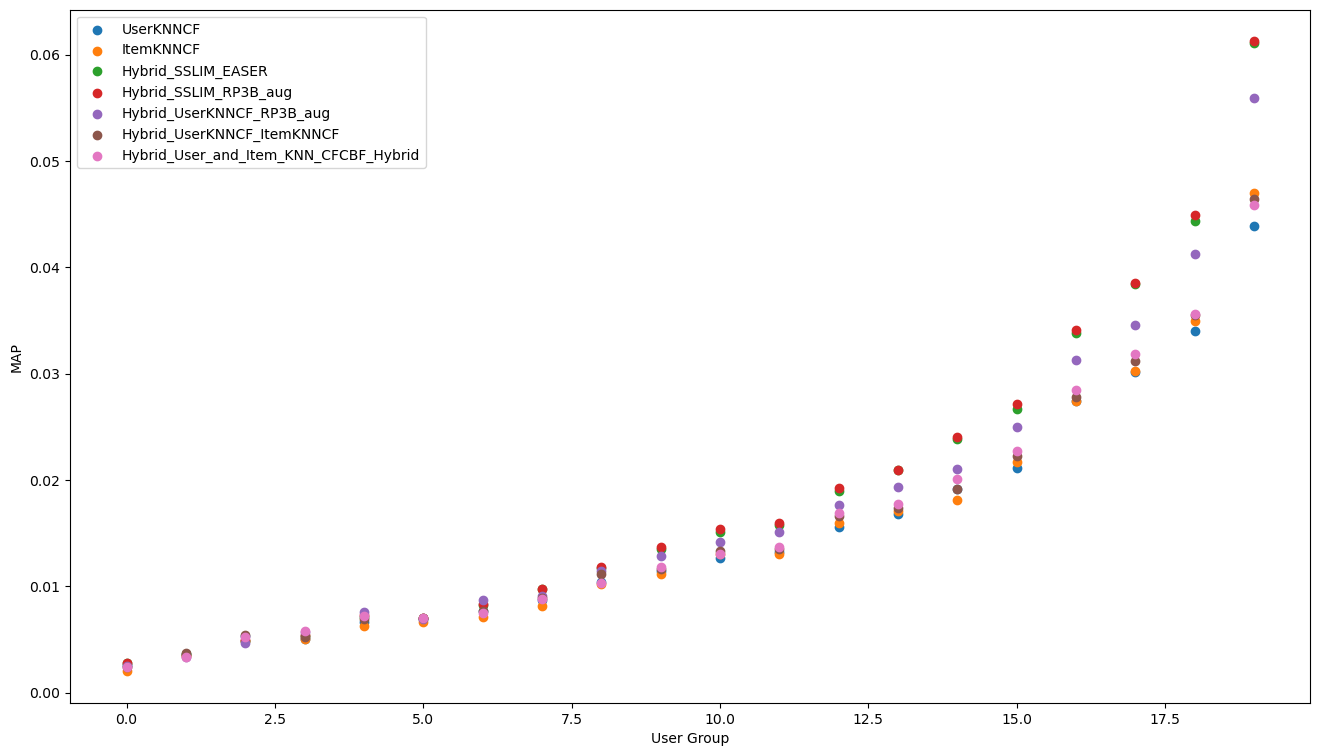

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    if label != "HybridRecommender_5":
        results = MAP_recommender_per_group[label]
        plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
        print(len(results))
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

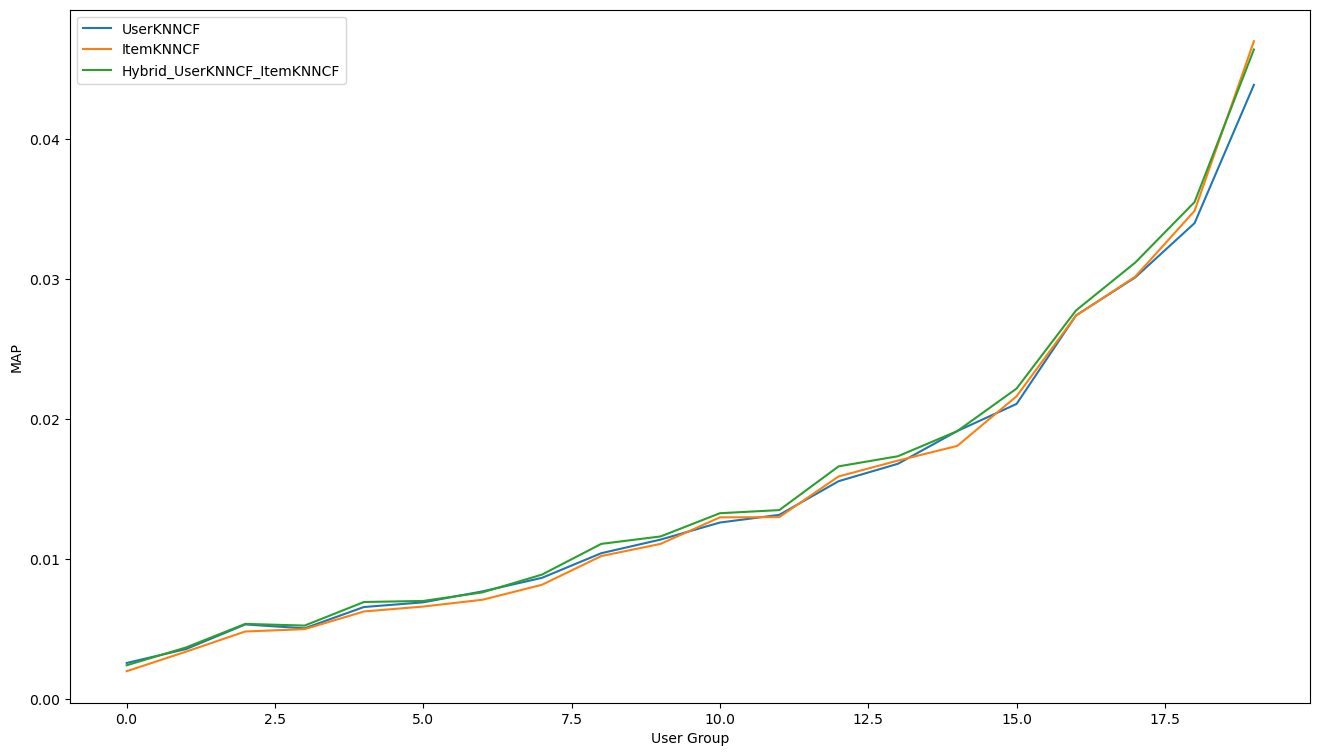

'\n"SLIMElasticNetRecommender": SLIMElasticNetRecommender,\n        "UserKNNCF": UserKNNCFRecommender,\n        "ItemKNNCF": ItemKNNCFRecommender,\n        "RP3betaRecommender_aug": RP3betaRecommender,\n        "RP3betaRecommender_pow": RP3betaRecommender,\n        "EASE_R": EASE_R_Recommender,\n        "HybridRecommender_5" : HybridRecommender_5,\n        "Hybrid_SSLIM_EASER": Hybrid_SSLIM_EASER,\n'

In [ ]:
import matplotlib.pyplot as pyplot
%matplotlib inline
_ = plt.figure(figsize=(16, 9))

results = MAP_recommender_per_group["UserKNNCF"]
pyplot.plot(np.arange(0,len(results)),results, label="UserKNNCF")
results = MAP_recommender_per_group["ItemKNNCF"]
pyplot.plot(np.arange(0,len(results)),results, label="ItemKNNCF")
results = MAP_recommender_per_group["Hybrid_UserKNNCF_ItemKNNCF"]
pyplot.plot(np.arange(0,len(results)),results, label="Hybrid_UserKNNCF_ItemKNNCF")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()

'''
"SLIMElasticNetRecommender": SLIMElasticNetRecommender,
        "UserKNNCF": UserKNNCFRecommender,
        "ItemKNNCF": ItemKNNCFRecommender,
        "RP3betaRecommender_aug": RP3betaRecommender,
        "RP3betaRecommender_pow": RP3betaRecommender,
        "EASE_R": EASE_R_Recommender,
        "HybridRecommender_5" : HybridRecommender_5,
        "Hybrid_SSLIM_EASER": Hybrid_SSLIM_EASER,
'''